# Analisis de Twitter posts de Lomeli

### Modulo Clean Data

In [3]:
#Mo
# Importamos las librerías

import re
import nltk
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from nltk.tokenize import RegexpTokenizer

import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

###Diccionarios en español para el análisis de polaridad
nltk.download('punkt')
# Tokenización
# Descargar el conjunto de stopwords en español si no lo tienes
nltk.download('stopwords')
# Análisis de polaridad
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /home/cygnus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cygnus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df_posts = pd.read_csv("twitter_lomeli.csv", usecols=["css-4rbku5", "css-901oao 5", "css-901oao 7", "css-901oao 8", "css-901oao 9", "css-901oao 10", "css-901oao 13"])
df_posts = df_posts.rename(columns= {
    "css-4rbku5": "fecha", "css-901oao 5": "texto", "css-901oao 7": "comentarios", "css-901oao 8":"rts",
    "css-901oao 9":"likes", "css-901oao 10":"views", "css-4rbku5 2":"hashtags", "css-901oao 13":"texto2"})
df_posts

,fecha,texto,comentarios,rts,likes,views,texto2
0,22 ene.,Para que la transformación llegue a Jalisco de...,122,57.0,211,"40,1 mil",NaN
1,19h,En Tepa y todos los Altos hay gente trabajador...,3,5.0,43,710,NaN
2,sams.com.mx,/?twclid=219wqod8qtgqv6e93zaurs7wm,sams.com.mx,1.0,3,37,NaN
3,14 oct.,Conocer de cerca a la gente y sus historias me...,5,8.0,52,1.091,NaN
4,13 oct.,En el oriente de Guadalajara y en todo Jalisco...,10,20.0,69,2.613,NaN
...,...,...,...,...,...,...,...
59,11 sept.,Solamente desde la honestidad podemos construi...,45,17.0,73,3.483,NaN
60,11 sept.,Han sido dos años de un gobierno en Guadalajar...,2,42.0,NaN,594,no descansaremos hasta que…
61,10 sept.,Esta mañana participé en la Tercera Sesión Ord...,5,11.0,67,2.465,", donde se entregó la constancia que acredita ..."
62,10 sept.,¡Listo para acompañar a nuestra compañera,19,19.0,115,4.185,en el Consejo Nacional de MORENA!


In [6]:
df_views = df_posts[["comentarios", "rts", "likes", "views"]]
df_posts = df_posts[['texto', 'texto2']]
df_posts = df_posts.fillna('')
df_posts["texto"] = df_posts.texto + ' ' + df_posts.texto2

In [9]:
import re

def limpiar_texto(texto):
    # Eliminar caracteres especiales y números
    texto_limpio = re.sub(r'[^\w\sáéíóúüÁÉÍÓÚÜñ]', '', texto, flags=re.UNICODE)
    # Eliminar espacios en blanco adicionales y convertir a minúsculas
    texto_limpio = ' '.join(texto_limpio.split()).lower()
    return texto_limpio

df_posts["texto"] = df_posts["texto"].apply(limpiar_texto)
df_posts['texto'] = df_posts['texto'].str.lower()
tokenizer = RegexpTokenizer(r'\w+')
df_posts['tokens'] = df_posts['texto'].apply(nltk.tokenize.word_tokenize)
df_posts = df_posts.drop("texto2", axis=1)
df_posts.to_csv("posts_x.csv")
df_posts

,texto,tokens
0,para que la transformación llegue a jalisco de...,"[para, que, la, transformación, llegue, a, jal..."
1,en tepa y todos los altos hay gente trabajador...,"[en, tepa, y, todos, los, altos, hay, gente, t..."
2,twclid219wqod8qtgqv6e93zaurs7wm,[twclid219wqod8qtgqv6e93zaurs7wm]
3,conocer de cerca a la gente y sus historias me...,"[conocer, de, cerca, a, la, gente, y, sus, his..."
4,en el oriente de guadalajara y en todo jalisco...,"[en, el, oriente, de, guadalajara, y, en, todo..."
...,...,...
59,solamente desde la honestidad podemos construi...,"[solamente, desde, la, honestidad, podemos, co..."
60,han sido dos años de un gobierno en guadalajar...,"[han, sido, dos, años, de, un, gobierno, en, g..."
61,esta mañana participé en la tercera sesión ord...,"[esta, mañana, participé, en, la, tercera, ses..."
62,listo para acompañar a nuestra compañera en el...,"[listo, para, acompañar, a, nuestra, compañera..."


In [10]:
# Eliminacion de Stopwords

# Limpieza de Stop_words
stop_words.extend(("q", "d", "van", "si", "pa", "así", "ser", "solo", "tan", "va", "as", "aquí", "hacia","dra", "día","hoy","dd","drcarloslomeli",
                "le", "con","ella", "qué", "por", "qu", "ers", "das", "ve", "jajaja", "jeje", "La", "nimo", "ms", "da","doccast",
                "drcarloslomeli"))

##########NUBE DE PALABRAS
def preprocess_text(text):
    words = text # Tokenizar y convertir a minúsculas
    words = [word for word in words if word.isalpha()]  # Eliminar caracteres no alfabéticos
    words = [word for word in words if word not in stop_words]  # Eliminar palabras vacías
    return words


preprocessed_text = df_posts["tokens"].apply(preprocess_text)

preprocessed_text

0     [transformación, llegue, jalisco, debemos, cum...
1     [tepa, altos, gente, trabajadora, buena, dedic...
2                                                    []
3     [conocer, cerca, gente, historias, motiva, lle...
4     [oriente, guadalajara, jalisco, respira, fuert...
                            ...                        
59    [solamente, honestidad, podemos, construir, me...
60    [sido, dos, años, gobierno, guadalajara, lleno...
61    [mañana, participé, tercera, sesión, ordinaria...
62    [listo, acompañar, compañera, consejo, naciona...
63    [recorrido, refuerza, convicción, jalisco, cla...
Name: tokens, Length: 64, dtype: object

In [11]:
# Unimos todas las listas de palabras en una sola lista
all_words = [word for sublist in preprocessed_text.values for word in sublist]

# Creamos un DataFrame con las palabras y sus frecuencias
word_counts = pd.Series(all_words).value_counts()

# Tomamos las palabras más comunes (puedes ajustar este valor según tus necesidades)
top_words = word_counts.head(10)
top_words.to_csv("top_words_posts.csv")

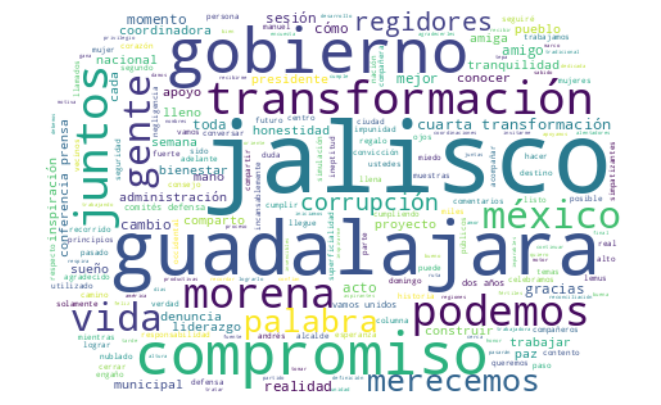

In [46]:
import numpy as np
# Unir las palabras en un solo texto (separadas por espacios)
texto = " ".join(all_words)
# Cículo
x, y = np.ogrid[:300, :500]
mask = (x - 150) ** 2 + (y - 250) ** 2 > 230 ** 2
mask = 255 * mask.astype(int)
# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white", mask=mask).generate(texto)
# Mostrar la nube de palabras utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Desactivar ejes
plt.savefig("nube_palabras.png", dpi=300)
plt.show()

## Topicos y Temas Emergentes

In [47]:
import spacy

nlp = spacy.load("es_core_news_sm")

# Función para preprocesar el texto
def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

# Aplicar el preprocesamiento a cada fila del DataFrame
df_posts['texto_preprocesado'] = df_posts.texto.apply(preprocess_text)
df_posts

,texto,tokens,texto_preprocesado
0,para que la transformación llegue a jalisco de...,"[para, que, la, transformación, llegue, a, jal...","[transformación, llegar, jalisco, deber, cumpl..."
1,en tepa y todos los altos hay gente trabajador...,"[en, tepa, y, todos, los, altos, hay, gente, t...","[tepa, alto, gente, trabajador, dedicado, apoy..."
2,twclid219wqod8qtgqv6e93zaurs7wm,[twclid219wqod8qtgqv6e93zaurs7wm],[]
3,conocer de cerca a la gente y sus historias me...,"[conocer, de, cerca, a, la, gente, y, sus, his...","[cerca, gente, historia, motivar, llenar, vida..."
4,en el oriente de guadalajara y en todo jalisco...,"[en, el, oriente, de, guadalajara, y, en, todo...","[oriente, guadalajara, jalisco, respirar, fuer..."
...,...,...,...
59,solamente desde la honestidad podemos construi...,"[solamente, desde, la, honestidad, podemos, co...","[honestidad, construir, realidad, realidad, bi..."
60,han sido dos años de un gobierno en guadalajar...,"[han, sido, dos, años, de, un, gobierno, en, g...","[año, gobierno, guadalajara, lleno, corrupción..."
61,esta mañana participé en la tercera sesión ord...,"[esta, mañana, participé, en, la, tercera, ses...","[mañana, participé, sesión, ordinario, entrega..."
62,listo para acompañar a nuestra compañera en el...,"[listo, para, acompañar, a, nuestra, compañera...","[listo, acompañar, compañera, consejo, naciona..."


In [48]:

from nltk.util import ngrams

# Generación de bigramas con spaCy
nlp = spacy.load("es_core_news_sm")

def generar_bigramas_spacy(texto):
    doc = nlp(texto)
    bigramas = [(doc[i].text, doc[i + 1].text) for i in range(len(doc) - 1)]
    return bigramas

df_posts['bigramas_spacy'] = df_posts['texto'].apply(generar_bigramas_spacy)

# Generación de bigramas con NLTK
def generar_bigramas_nltk(texto):
    tokens = word_tokenize(texto)
    bigramas = list(ngrams(tokens, 3))
    return bigramas

df_posts['bigramas_nltk'] = df_posts['texto'].apply(generar_bigramas_nltk)

# Visualización del DataFrame resultante
df_posts

,texto,tokens,texto_preprocesado,bigramas_spacy,bigramas_nltk
0,para que la transformación llegue a jalisco de...,"[para, que, la, transformación, llegue, a, jal...","[transformación, llegar, jalisco, deber, cumpl...","[(para, que), (que, la), (la, transformación),...","[(para, que, la), (que, la, transformación), (..."
1,en tepa y todos los altos hay gente trabajador...,"[en, tepa, y, todos, los, altos, hay, gente, t...","[tepa, alto, gente, trabajador, dedicado, apoy...","[(en, tepa), (tepa, y), (y, todos), (todos, lo...","[(en, tepa, y), (tepa, y, todos), (y, todos, l..."
2,twclid219wqod8qtgqv6e93zaurs7wm,[twclid219wqod8qtgqv6e93zaurs7wm],[],[],[]
3,conocer de cerca a la gente y sus historias me...,"[conocer, de, cerca, a, la, gente, y, sus, his...","[cerca, gente, historia, motivar, llenar, vida...","[(conocer, de), (de, cerca), (cerca, a), (a, l...","[(conocer, de, cerca), (de, cerca, a), (cerca,..."
4,en el oriente de guadalajara y en todo jalisco...,"[en, el, oriente, de, guadalajara, y, en, todo...","[oriente, guadalajara, jalisco, respirar, fuer...","[(en, el), (el, oriente), (oriente, de), (de, ...","[(en, el, oriente), (el, oriente, de), (orient..."
...,...,...,...,...,...
59,solamente desde la honestidad podemos construi...,"[solamente, desde, la, honestidad, podemos, co...","[honestidad, construir, realidad, realidad, bi...","[(solamente, desde), (desde, la), (la, honesti...","[(solamente, desde, la), (desde, la, honestida..."
60,han sido dos años de un gobierno en guadalajar...,"[han, sido, dos, años, de, un, gobierno, en, g...","[año, gobierno, guadalajara, lleno, corrupción...","[(han, sido), (sido, dos), (dos, años), (años,...","[(han, sido, dos), (sido, dos, años), (dos, añ..."
61,esta mañana participé en la tercera sesión ord...,"[esta, mañana, participé, en, la, tercera, ses...","[mañana, participé, sesión, ordinario, entrega...","[(esta, mañana), (mañana, participé), (partici...","[(esta, mañana, participé), (mañana, participé..."
62,listo para acompañar a nuestra compañera en el...,"[listo, para, acompañar, a, nuestra, compañera...","[listo, acompañar, compañera, consejo, naciona...","[(listo, para), (para, acompañar), (acompañar,...","[(listo, para, acompañar), (para, acompañar, a..."


In [49]:
from nltk.collocations import *

flatten_corpus = [w for l in df_posts.bigramas_spacy for w in l]

treshold = 3

bigrams = [bigram for bigram in flatten_corpus if len(bigram[0])>treshold and len(bigram[1])>treshold]

In [50]:
bigram_measure = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(bigrams)
finder.apply_freq_filter(2)
colocaciones = finder.nbest(bigram_measure.pmi, 20)
colocaciones

[('puede', 'lograr'),
 ('pueblo', 'todo'),
 ('andrés', 'manuel'),
 ('estamos', 'llamados'),
 ('gobierno', 'municipal'),
 ('vamos', 'unidos'),
 ('cuarta', 'transformación'),
 ('podemos', 'construir'),
 ('todo', 'jalisco'),
 ('juntos', 'podemos')]

In [51]:
# Función para lematizar el texto
def lematizar_texto(texto):
    doc = nlp(texto)
    lemas = [token.lemma_ for token in doc]
    return " ".join(lemas)

# Aplicar la función de lematización a cada fila del DataFrame
df_posts['texto_lematizado'] = df_posts.texto.apply(lematizar_texto)
df_posts

,texto,tokens,texto_preprocesado,bigramas_spacy,bigramas_nltk,texto_lematizado
0,para que la transformación llegue a jalisco de...,"[para, que, la, transformación, llegue, a, jal...","[transformación, llegar, jalisco, deber, cumpl...","[(para, que), (que, la), (la, transformación),...","[(para, que, la), (que, la, transformación), (...",para que el transformación llegar a jalisco de...
1,en tepa y todos los altos hay gente trabajador...,"[en, tepa, y, todos, los, altos, hay, gente, t...","[tepa, alto, gente, trabajador, dedicado, apoy...","[(en, tepa), (tepa, y), (y, todos), (todos, lo...","[(en, tepa, y), (tepa, y, todos), (y, todos, l...",en tepa y todo el alto haber gente trabajador ...
2,twclid219wqod8qtgqv6e93zaurs7wm,[twclid219wqod8qtgqv6e93zaurs7wm],[],[],[],twclid219wqod8qtgqv6e93zaurs7wm
3,conocer de cerca a la gente y sus historias me...,"[conocer, de, cerca, a, la, gente, y, sus, his...","[cerca, gente, historia, motivar, llenar, vida...","[(conocer, de), (de, cerca), (cerca, a), (a, l...","[(conocer, de, cerca), (de, cerca, a), (cerca,...",conocer de cerca a el gente y su historia yo m...
4,en el oriente de guadalajara y en todo jalisco...,"[en, el, oriente, de, guadalajara, y, en, todo...","[oriente, guadalajara, jalisco, respirar, fuer...","[(en, el), (el, oriente), (oriente, de), (de, ...","[(en, el, oriente), (el, oriente, de), (orient...",en el oriente de guadalajara y en todo jalisco...
...,...,...,...,...,...,...
59,solamente desde la honestidad podemos construi...,"[solamente, desde, la, honestidad, podemos, co...","[honestidad, construir, realidad, realidad, bi...","[(solamente, desde), (desde, la), (la, honesti...","[(solamente, desde, la), (desde, la, honestida...",solamente desde el honestidad poder construir ...
60,han sido dos años de un gobierno en guadalajar...,"[han, sido, dos, años, de, un, gobierno, en, g...","[año, gobierno, guadalajara, lleno, corrupción...","[(han, sido), (sido, dos), (dos, años), (años,...","[(han, sido, dos), (sido, dos, años), (dos, añ...",haber ser dos año de uno gobierno en guadalaja...
61,esta mañana participé en la tercera sesión ord...,"[esta, mañana, participé, en, la, tercera, ses...","[mañana, participé, sesión, ordinario, entrega...","[(esta, mañana), (mañana, participé), (partici...","[(esta, mañana, participé), (mañana, participé...",este mañana participé en el tercero sesión ord...
62,listo para acompañar a nuestra compañera en el...,"[listo, para, acompañar, a, nuestra, compañera...","[listo, acompañar, compañera, consejo, naciona...","[(listo, para), (para, acompañar), (acompañar,...","[(listo, para, acompañar), (para, acompañar, a...",listo para acompañar a nuestro compañera en el...


## Topics con Spacy y Congruencia

In [52]:
# eliminar la función ner para acelerar el procesamiento
nlp.disable_pipes('ner')

from tqdm import tqdm

# dataset
dataset = df_posts['texto']
docs = []
for text in tqdm(nlp.pipe(dataset), total=len(dataset)):
    doc = nlp(text) 
    pt = [token.lemma_.lower() for token in doc if
           (len(token.lemma_) > 1 and token.pos_ == "NOUN" and 
          not token.is_stop)]
    docs.append(pt)

docs

100%|██████████| 64/64 [00:00<00:00, 66.66it/s]


[['transformación',
  'jalisco',
  'principio',
  'morena',
  'ruta',
  'unidad',
  'reconciliación'],
 ['alto', 'gente', 'apoyo', 'región', 'américa', 'gracia', 'domingo'],
 [],
 ['gente', 'historia', 'vida', 'privilegio', 'gracia'],
 ['oriente',
  'paz',
  'tranquilidad',
  'desarrollo',
  'bienestar',
  'gracias',
  'simpatizante',
  'partido'],
 ['nombre',
  'aspirante',
  'encuesta',
  'marco',
  'proceso',
  'definición',
  'coordinación',
  'defensa',
  'transformación'],
 [],
 ['gracias', 'altura', 'esperanza'],
 ['palabra', 'miedo', 'futuro'],
 ['momento',
  'agradecerl',
  'corazón',
  'palabra',
  'comentario',
  'motor',
  'fuente',
  'inspiración'],
 ['tema', 'denuncia'],
 ['conferencia', 'prensa', 'administración', 'gobierno'],
 ['semana', 'liderazgo', 'amor', 'compromiso', 'domingo'],
 ['honor',
  'compromiso',
  'transformación',
  'inspiración',
  'liderazgo',
  'coordinadora',
  'defensa'],
 ['muestra', 'cariño', 'palabra', 'aliento'],
 ['amiga', 'mujer', 'responsabil

In [53]:
from collections import Counter
from itertools import chain

counts_word_occurence = Counter(chain(*[x for x in docs]))

# Palabras con una sola ocurrencia
low_freq_words = {key:value for (key,value) in counts_word_occurence.items() if value==1}
docs = [[lemma for lemma in text if counts_word_occurence[lemma]>0] for text in docs]


In [55]:
docs_length=len(docs)
# calculate in how many documents a word appeared
counts_word_percentage = Counter(chain(*[set(x) for x in docs]))

# calculate in what % of all articles a word appears
counts_word_percentage = {key:(value/docs_length)*100 for (key,value) in counts_word_percentage.items()}
high_freq_words = {key:value for (key,value) in counts_word_percentage.items() if value>20}

high_freq_words

{'jalisco': 21.875}

In [56]:
import pprint

pp = pprint.PrettyPrinter(compact=True)
pp.pprint(docs)

[['transformación', 'jalisco', 'principio', 'morena', 'ruta', 'unidad',
  'reconciliación'],
 ['alto', 'gente', 'apoyo', 'región', 'américa', 'gracia', 'domingo'], [],
 ['gente', 'historia', 'vida', 'privilegio', 'gracia'],
 ['oriente', 'paz', 'tranquilidad', 'desarrollo', 'bienestar', 'gracias',
  'simpatizante', 'partido'],
 ['nombre', 'aspirante', 'encuesta', 'marco', 'proceso', 'definición',
  'coordinación', 'defensa', 'transformación'],
 [], ['gracias', 'altura', 'esperanza'], ['palabra', 'miedo', 'futuro'],
 ['momento', 'agradecerl', 'corazón', 'palabra', 'comentario', 'motor',
  'fuente', 'inspiración'],
 ['tema', 'denuncia'], ['conferencia', 'prensa', 'administración', 'gobierno'],
 ['semana', 'liderazgo', 'amor', 'compromiso', 'domingo'],
 ['honor', 'compromiso', 'transformación', 'inspiración', 'liderazgo',
  'coordinadora', 'defensa'],
 ['muestra', 'cariño', 'palabra', 'aliento'],
 ['amiga', 'mujer', 'responsabilidad', 'dra'], ['jalisco'],
 ['esposa', 'hija', 'bendición', '

<Axes: ylabel='Count'>

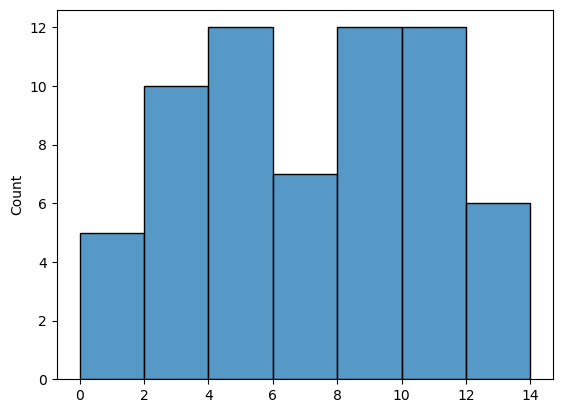

In [57]:
import seaborn as sns 

lengths =  [len(x) for x in docs]
# Build the histogram, distribution of lemmas in the texts
sns.histplot(lengths)

In [58]:
from gensim.models import CoherenceModel

# Defining dictionary and corpus with Gensim
dictionary = corpora.Dictionary(docs)
#dictionary.add_documents(colocaciones)  # Agregar n-gramas al diccionario

corpus = [dictionary.doc2bow(text) for text in docs]

def calculate_coherence(dictionary, corpus, docs, start, stop):
    scores = []
    for topics in range(start, stop):

        # defining the model
        lda_model = LdaModel(corpus, id2word=dictionary, num_topics=20, alpha='auto', eval_every=5)

        # U_mass coherence score
        cm_u_mass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        u_mass_coherence = cm_u_mass.get_coherence()

        # C_v coherence score
        cm_c_v = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
        c_v_coherence = cm_c_v.get_coherence()

        values = [topics, u_mass_coherence, c_v_coherence]

        scores.append(values)

    return scores

# calculare scores
scores = calculate_coherence(dictionary, corpus, docs, 5, 15)
scores

[[5, -16.88806039620776, 0.41408438232370753],
 [6, -16.970846402914837, 0.4093142854671541],
 [7, -15.87873570701872, 0.3550856530469133],
 [8, -16.388814590726305, 0.3947876129859854],
 [9, -16.349105296291842, 0.4015798437043995],
 [10, -16.429688633591976, 0.40659244370425884],
 [11, -16.197448355631966, 0.4068684974359898],
 [12, -17.03999051048852, 0.41780522716967383],
 [13, -16.935264384334573, 0.40865435474467704],
 [14, -15.880284282039705, 0.3745983704020413]]

Text(0.5, 1.0, 'u_mass coherence')

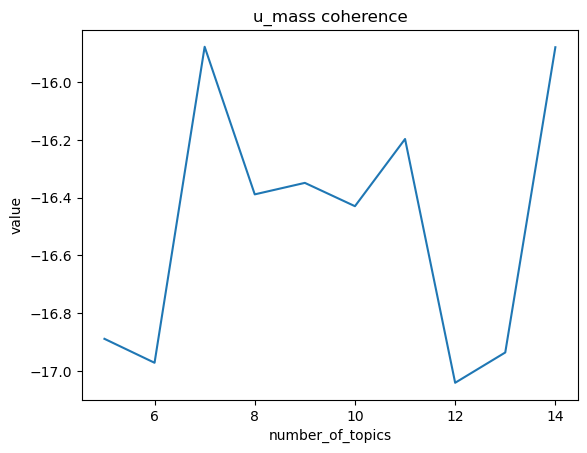

In [59]:
# scores to df
df = pd.DataFrame(scores, columns = ['number_of_topics','u_mass_coherence','c_v_coherence'])

# tidying the df
df = df.melt(id_vars=['number_of_topics'], value_vars=['u_mass_coherence','c_v_coherence'])

# Plotting u_mass_coherence
sns.lineplot(data=df.loc[df['variable'] == 'u_mass_coherence'], x="number_of_topics", y="value").set_title('u_mass coherence')

Text(0.5, 1.0, 'c_v coherence')

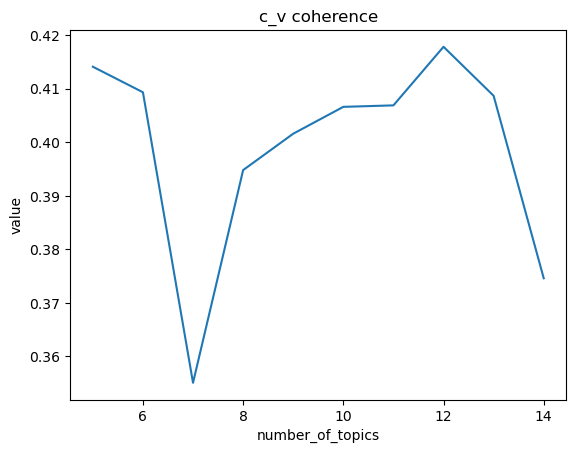

In [60]:
# Plotting c_v_coherence
sns.lineplot(data=df.loc[df['variable'] == 'c_v_coherence'], x="number_of_topics", y="value").set_title('c_v coherence')


In [65]:
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=5, alpha='auto', eval_every=5, passes=10)

# print topics
topics = lda_model.print_topics(-1)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.049*"jalisco" + 0.033*"transformación" + 0.028*"compromiso" + 0.023*"realidad" + 0.022*"defensa" + 0.017*"palabra" + 0.017*"momento" + 0.017*"comités" + 0.017*"inspiración" + 0.017*"liderazgo"')
(1, '0.019*"acto" + 0.019*"esperanza" + 0.019*"conferencia" + 0.019*"prensa" + 0.019*"jalisco" + 0.011*"compromiso" + 0.011*"compañera" + 0.011*"presidente" + 0.011*"2018" + 0.011*"camino"')
(2, '0.024*"gente" + 0.018*"apoyo" + 0.018*"mano" + 0.018*"transformación" + 0.018*"jalisco" + 0.018*"vida" + 0.012*"mujer" + 0.012*"paz" + 0.012*"tranquilidad" + 0.012*"simpatizante"')
(3, '0.022*"corrupción" + 0.022*"año" + 0.022*"gobierno" + 0.022*"simulación" + 0.022*"ineptitud" + 0.022*"superficialidad" + 0.022*"mujer" + 0.022*"regidor" + 0.012*"futuro" + 0.012*"prensa"')
(4, '0.034*"morena" + 0.025*"regidor" + 0.020*"corrupción" + 0.018*"administración" + 0.018*"gobierno" + 0.018*"principio" + 0.018*"transformación" + 0.018*"pueblo" + 0.017*"negligencia" + 0.010*"jalisco"')


In [66]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
viz


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.145746 -0.024906       1        1  30.490858
2     -0.076734 -0.110664       2        1  28.212147
4     -0.045883  0.086976       3        1  16.622340
1      0.000796  0.011795       4        1  13.868146
3     -0.023925  0.036799       5        1  10.806509, topic_info=             Term      Freq      Total Category  logprob  loglift
1          morena  3.000000   3.000000  Default  30.0000  30.0000
167       regidor  3.000000   3.000000  Default  29.0000  29.0000
192    corrupción  3.000000   3.000000  Default  28.0000  28.0000
62          mujer  2.000000   2.000000  Default  27.0000  27.0000
118           año  2.000000   2.000000  Default  26.0000  26.0000
..            ...       ...        ...      ...      ...      ...
49       gobierno  1.044038   5.359737   Topic5  -3.8072   0.5892
22            paz  0.569473   2.462373   Topic5  -4.4134   0.7609
24   tranquilidad  0.569473   2.462373   Topic5  -4.4134   0.7609
54         semana  0.569471   2.365804   Topic5  -4.4134   0.8009
0         jalisco  0.569467  11.198446   Topic5  -4.4134  -0.7538

[245 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
91        4  0.884084       2011
117       2  0.773227       2017
92        4  0.884084       2018
152       3  0.847043       2023
81        2  0.773226  activista
...     ...       ...        ...
173       2  0.773227     vecina
16        2  0.612887       vida
16        3  0.306444       vida
89        2  0.773227  violencia
90        2  0.773226    víctima

[256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])

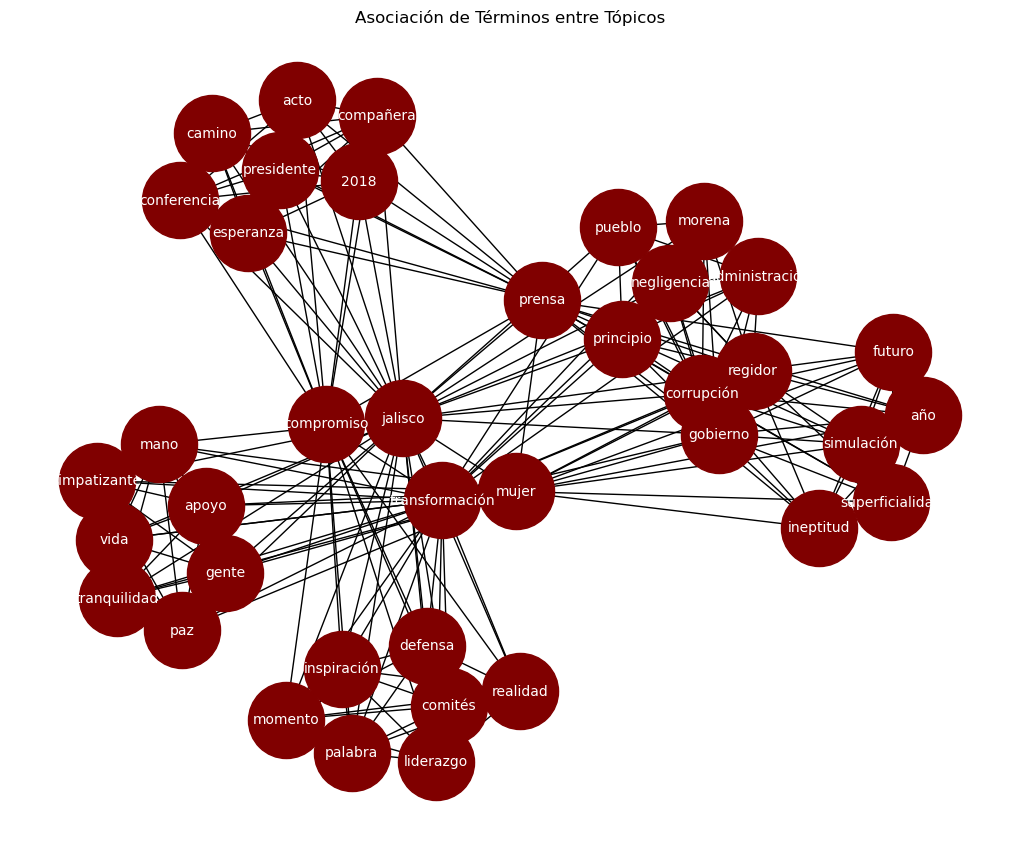

In [67]:
import networkx as nx

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='white')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()